# 2. Wrangle the Raster Data (3 layers)
# Part 3: MACA v2 THREDDS - download 2 climate scenarios

In [1]:
# Download stored variables from previous notebooks

# Variables from study area download
%store -r habitat_suitability_data_dir usfs_grasslands_path 
%store -r comanche_grassland_gdf pawnee_grassland_gdf usfs_grasslands_gdf


In [25]:
# Prepare for download Part 1 of 1
## Import packages that will help with...

# Reproducible file paths
import os # Reproducible file paths
import pathlib # Find the home folder

# Find files by pattern
import matplotlib.pyplot as plt # Overlay pandas (vector) and xarry (raster) plots 
import rioxarray as rxr # Work with geospatial raster data

# Work with tabular, vector, and raster data
import geopandas as gpd # work with vector data
import numpy as np #
import pandas as pd # Group and aggregate
import xarray as xr # Adjust images

In [24]:
# Create function  that converts longitude that is in the 0-360 
# range, to the -180 to 180 range 
def convert_longitude(longitude):
    """ Convert logitude range from  0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

# Create list to save data arrays back to
maca_da_list = []

# Iterate through multiple sites or study areas
for site_name, site_gdf in {
    'comanche':comanche_grassland_gdf,'pawnee':pawnee_grassland_gdf}.items():
    # Iterate through multiple variables, e.g. precipitation
    for variable in ['pr']:
        # Iterate through different emissions scenarios
        for scenario in ['historical', 'rcp85']:
            # Iterate through start years and end years
            for scenario, start_year in {
                'historical': 2000, 'rcp85': 2091}.items():
                end_year = start_year + 4
                # Define template url for MACA v2 download
                maca_url = (
                    'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2'
                    f'/CCSM4/macav2metdata_{variable}_CCSM4_r6i1p1_'
                    f'{scenario}_{start_year}_{end_year}_CONUS_monthly.nc')
                # Connect to the raster image
                maca_da = xr.open_dataset(maca_url).squeeze().precipitation
                # Get the study bounds
                bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
                # Apply function convert_longitude to convert longitude
                maca_da = maca_da.assign_coords(
                    lon = ('lon', 
                    [convert_longitude(l) for l in maca_da.lon.values]))
                # Set spatial dimensions - need lon = x-axis and lat = y-axis.
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
                # Crop the raster image to the bounds of the study area(s)
                maca_da = maca_da.rio.clip_box(*bounds)
                # Append the data array to the list
                maca_da_list.append(dict(
                    site_name = site_name,
                    variable = variable,
                    scenario = scenario,
                    start_year = start_year,
                    da = maca_da
                    ))           
# Convert maca_da_list to df, call maca_df to see it
maca_df = pd.DataFrame(maca_da_list)
maca_df

,site_name,variable,scenario,start_year,da
0,comanche,pr,historical,2000,[[[<xarray.DataArray 'precipitation' ()> Size:...
1,comanche,pr,rcp85,2091,[[[<xarray.DataArray 'precipitation' ()> Size:...
2,comanche,pr,historical,2000,[[[<xarray.DataArray 'precipitation' ()> Size:...
3,comanche,pr,rcp85,2091,[[[<xarray.DataArray 'precipitation' ()> Size:...
4,pawnee,pr,historical,2000,[[[<xarray.DataArray 'precipitation' ()> Size:...
5,pawnee,pr,rcp85,2091,[[[<xarray.DataArray 'precipitation' ()> Size:...
6,pawnee,pr,historical,2000,[[[<xarray.DataArray 'precipitation' ()> Size:...
7,pawnee,pr,rcp85,2091,[[[<xarray.DataArray 'precipitation' ()> Size:...


In [27]:
# Call the maca_da_list to see it
maca_da_list

[{'site_name': 'comanche',
  'variable': 'pr',
  'scenario': 'historical',
  'start_year': 2000,
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 23, lon: 43)> Size: 237kB
  [59340 values with dtype=float32]
  Coordinates:
    * lat      (lat) float64 184B 36.98 37.02 37.06 37.1 ... 37.81 37.85 37.9
    * time     (time) object 480B 2000-01-15 00:00:00 ... 2004-12-15 00:00:00
    * lon      (lon) float64 344B -104.1 -104.0 -104.0 ... -102.4 -102.4 -102.3
      crs      int64 8B 0
  Attributes:
      long_name:      Monthly Precipitation Amount
      units:          mm
      standard_name:  precipitation
      cell_methods:   time: sum(interval: 24 hours): sum over days
      comments:       Total monthly precipitation at surface: includes both liq...
      _ChunkSizes:    [ 10  44 107]},
 {'site_name': 'comanche',
  'variable': 'pr',
  'scenario': 'rcp85',
  'start_year': 2091,
  'da': <xarray.DataArray 'precipitation' (time: 60, lat: 23, lon: 43)> Size: 237kB
  [59340 values 

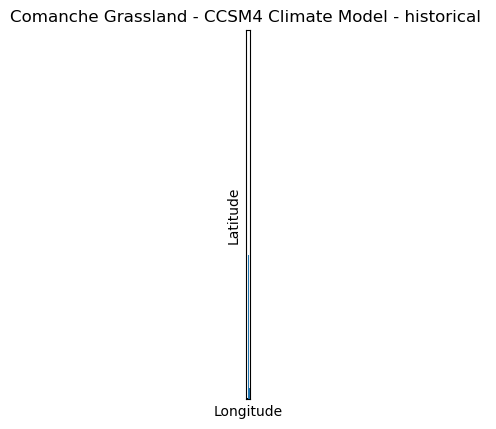

In [32]:
# Test by plotting 1 climate scenario on 1 study area
maca_da_list[0]['da'].plot(
    #cbar_kwargs={"label": " (meters)"},
    #robust=True,
    #cmap='terrain',
)
# Overlay the boundary of the same study area
comanche_grassland_gdf.boundary.plot(ax=plt.gca(),
    color='black').set(
        title='Comanche Grassland - CCSM4 Climate Model - historical ',
        xlabel='Longitude', 
        ylabel='Latitude',
        xticks=[],
        yticks=[] 
    )
plt.show()